# **Problem Description: Impact of Dynamic Routing Outages on Delivery Time per Parcel**

## **Background**

The postal service operates across multiple delivery centers, each covering specific regions. These centers execute daily parcel deliveries through predefined delivery routes (tours). To enhance efficiency, an external vendor provides a **dynamic routing system** that optimizes delivery routes in real-time based on parcel volume, geography, and other logistical constraints.

Occasionally, this dynamic routing system experiences **critical outages**, forcing delivery centers to revert to manual route planning. While the business expects that dynamic routing should reduce **delivery time per parcel (seconds per parcel)**—the key performance metric—it is unclear what actual impact outages have on efficiency.

## **Objective**

The goal of this analysis is to measure the impact of **dynamic routing outages** on delivery time per parcel. Specifically, we seek to answer:

- **Does the absence of dynamic routing increase, decrease, or have no effect on delivery time per parcel?**
- **If there is an effect, how large is it?**
- **Are there conditions under which manual routing performs as well as, or better than, dynamic routing?**

## **Outage Data Considerations**

- There are **ten major outage incidents** identified for 2024, affecting a significant number of delivery centers.
- The remaining days in 2024 are considered **normal operational days** without major disruptions.
- While smaller failures may have occurred, they are not observed in the available dataset.
- Among the ten major outages, some may have had a **larger impact than others**, requiring consideration of different levels of severity.

## **Challenges & Assumptions**

### **Observed Factors:**

1. **Delivery Center Differences:** Centers have varying operational efficiencies, workforce experience, and geographical constraints.
2. **Parcel Volume:** Higher volumes may benefit from economies of scale, reducing per-parcel delivery time.
3. **Urban vs. Rural Routes:** Urban centers might be more optimized for efficiency, whereas rural routes may inherently take longer.
4. **Outage Incidents:** Vary in frequency and duration, potentially affecting different centers at different times.
5. **Outage Severity:** Some outages may have had a more significant impact than others, and this should be accounted for in the analysis.

### **Unobserved but Potentially Collectable Factors:**

- **Parcel Attributes**: Weight, volume, and special handling requirements.
- **Delivery Personnel Seniority**: More experienced couriers may offset inefficiencies introduced by outages.
- **Weather and Traffic Conditions**: Could disproportionately affect delivery time during outages.

### **Modeling Considerations:**

1. **Heteroscedasticity:** Initial analysis suggests that variance in time per parcel is larger for small parcel volumes (e.g., fewer than 60 parcels per tour).
2. **Data Availability:** Parcel-level and tour-level data, along with outage timestamps and delivery center information, will be required.
3. **Control for Confounders:** Differences across delivery centers, time trends, and economies of scale need to be accounted for.
4. **Outage Severity Categorization:** Consider different levels of impact among the ten identified outages.

## **Potential Analytical Approaches**

- **Difference-in-Differences (DiD):** Compare changes in delivery time before and after outages using unaffected delivery centers as a control group.
- **Fixed Effects Regression:** Control for delivery center-specific factors while measuring the impact of outages.
- **Instrumental Variables (IV):** If outages correlate with other operational inefficiencies, an external instrument may be required.
- **Machine Learning Approaches:** Random forests or causal inference methods (e.g., causal forests) to explore non-linear effects.

## **Next Steps**

1. **Data Validation:** Confirm availability and structure of key datasets (parcel-level, tour-level, outage records).
2. **Exploratory Analysis:** Identify trends in delivery time per parcel before and during outages.
3. **Outage Severity Categorization:** Assess whether different outages had varying levels of impact.
4. **Hypothesis Testing:** Evaluate statistical significance of outage effects using robust regression models.
5. **Business Interpretation:** Translate results into operational recommendations for mitigating outage impacts.

---

## **Questions for Refinement:**

- Are there additional operational factors that could influence time per parcel?
- Do outages have a varying impact based on parcel type (e.g., express vs. standard)?
- What backup strategies do delivery centers use during outages, and can we incorporate them into the analysis?



In [1]:
import pandas as pd

In [2]:
from src.simulation.simulator import run_simulation
from src.analysis.analyzer import analyze_results
from src.analysis.visualizer import plot_results





In [3]:
df = run_simulation()
df.head()

,date,center_id,tour_id,n_parcels,delivery_time,delivery_time_per_parcel,is_outage
0,2024-01-01,0,0,179,14605.755517,81.596400,True
1,2024-01-01,0,1,230,16992.111694,73.878746,True
2,2024-01-01,0,2,149,5889.732012,39.528403,True
3,2024-01-01,0,3,214,13874.285494,64.833110,True
4,2024-01-01,0,4,213,13956.682527,65.524331,True


In [4]:
# Add seasonality variables
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.dayofweek
df['week_of_year'] = df['date'].dt.isocalendar().week
df['month'] = df['date'].dt.month 
df['quarter'] = df['date'].dt.quarter


In [5]:
# Display the columns in the dataframe
print(df.columns)

# Count the unique number of outage days in the dataframe
outage_days = df[df['is_outage'] == True]['date'].dt.date.nunique()
print(f"Number of unique outage days: {outage_days}")


Index(['date', 'center_id', 'tour_id', 'n_parcels', 'delivery_time',
       'delivery_time_per_parcel', 'is_outage', 'day_of_week', 'week_of_year',
       'month', 'quarter'],
      dtype='object')
Number of unique outage days: 9


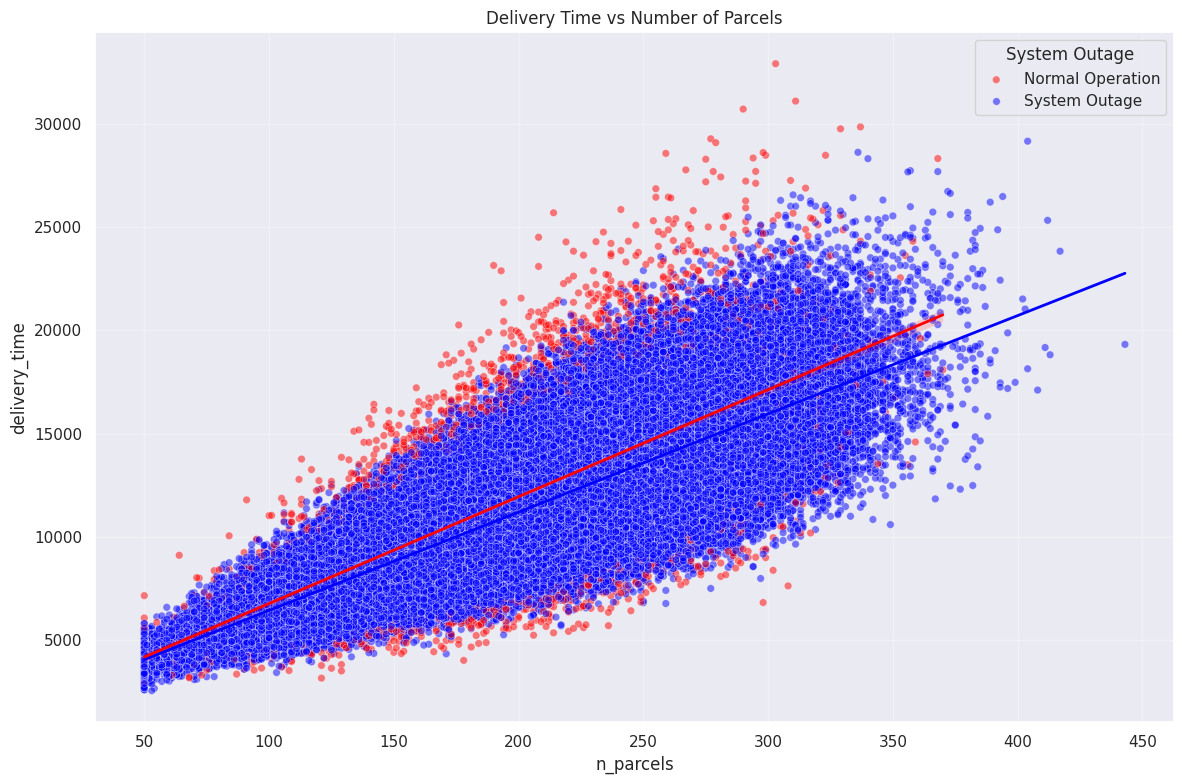

In [11]:
# Create a scatter plot of delivery time vs number of parcels
# Distinguish between outage days and normal days
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df, 
    x='n_parcels', 
    y='delivery_time',
    hue='is_outage',
    alpha=0.5,
    palette={True: 'red', False: 'blue'},
    s=30
)

plt.title('Delivery Time vs Number of Parcels')
plt.xlabel('Number of Parcels')
plt.ylabel('Delivery Time (seconds)')
plt.legend(title='System Outage', labels=['Normal Operation', 'System Outage'])

# Add a best fit line for each group
sns.regplot(
    data=df[~df['is_outage']], 
    x='n_parcels', 
    y='delivery_time',
    scatter=False,
    color='blue',
    line_kws={'linewidth': 2}
)

sns.regplot(
    data=df[df['is_outage']], 
    x='n_parcels', 
    y='delivery_time',
    scatter=False,
    color='red',
    line_kws={'linewidth': 2}
)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


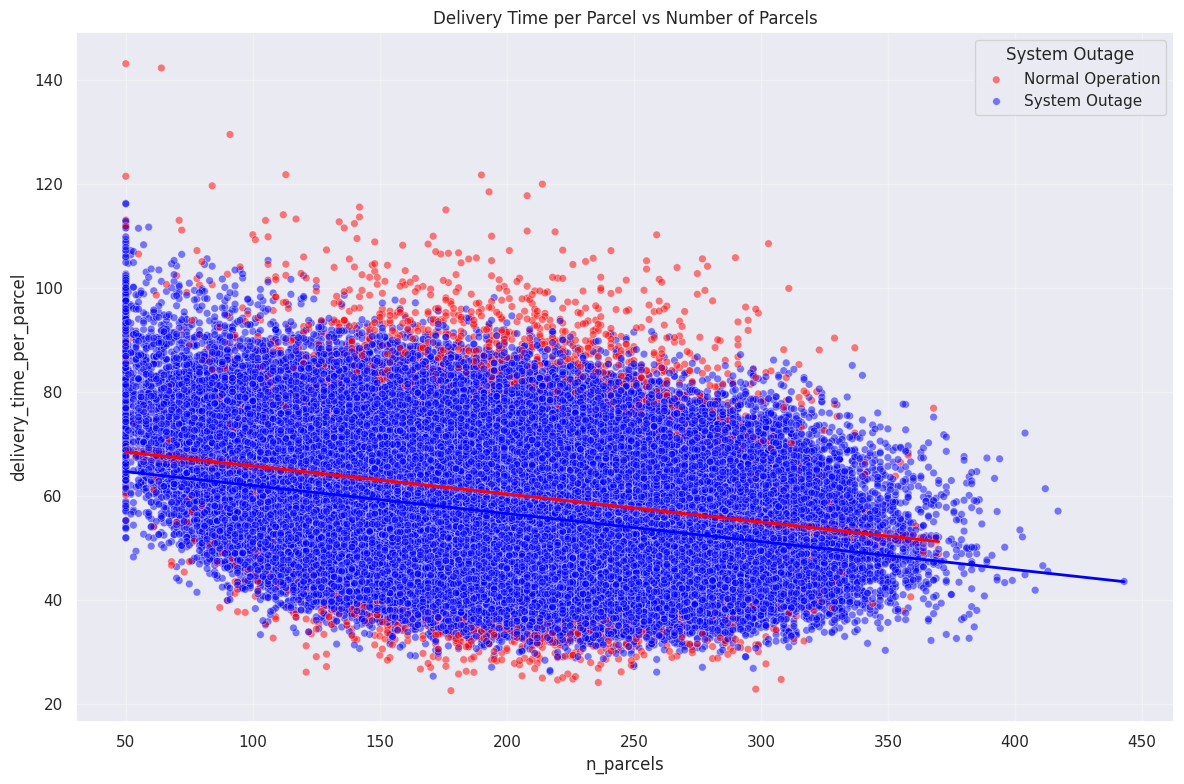

In [12]:
# Create a scatter plot of delivery time per parcel vs number of parcels
# Distinguish between outage days and normal days
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df, 
    x='n_parcels', 
    y='delivery_time_per_parcel',
    hue='is_outage',
    alpha=0.5,
    palette={True: 'red', False: 'blue'},
    s=30
)

plt.title('Delivery Time per Parcel vs Number of Parcels')
plt.xlabel('Number of Parcels')
plt.ylabel('Delivery Time per Parcel (seconds)')
plt.legend(title='System Outage', labels=['Normal Operation', 'System Outage'])

# Add a best fit line for each group
sns.regplot(
    data=df[~df['is_outage']], 
    x='n_parcels', 
    y='delivery_time_per_parcel',
    scatter=False,
    color='blue',
    line_kws={'linewidth': 2}
)

sns.regplot(
    data=df[df['is_outage']], 
    x='n_parcels', 
    y='delivery_time_per_parcel',
    scatter=False,
    color='red',
    line_kws={'linewidth': 2}
)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



In [15]:
# Regress delivery time on number of parcels and delivery center id
import statsmodels.api as sm
import numpy as np

# Convert categorical variables to numeric
df['center_id'] = df['center_id'].astype('category')
df['month'] = df['month'].astype('category')

# Create formula for regression
formula = "delivery_time ~ C(is_outage) + n_parcels + C(center_id)"

# Fit model using from_formula
model = sm.OLS.from_formula(formula, data=df).fit()

# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          delivery_time   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                 2.132e+04
Date:                Sun, 02 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:30:30   Log-Likelihood:            -2.5539e+06
No. Observations:              292083   AIC:                         5.108e+06
Df Residuals:                  292040   BIC:                         5.108e+06
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             2833.7103 

Residual Statistics:
Mean of residuals: 0.000000
Standard deviation of residuals: 1517.438609
Skewness of residuals: 0.267737
Kurtosis of residuals: 1.316799
Shapiro-Wilk test on sample of 5000 residuals: W=0.983546, p-value=0.000000


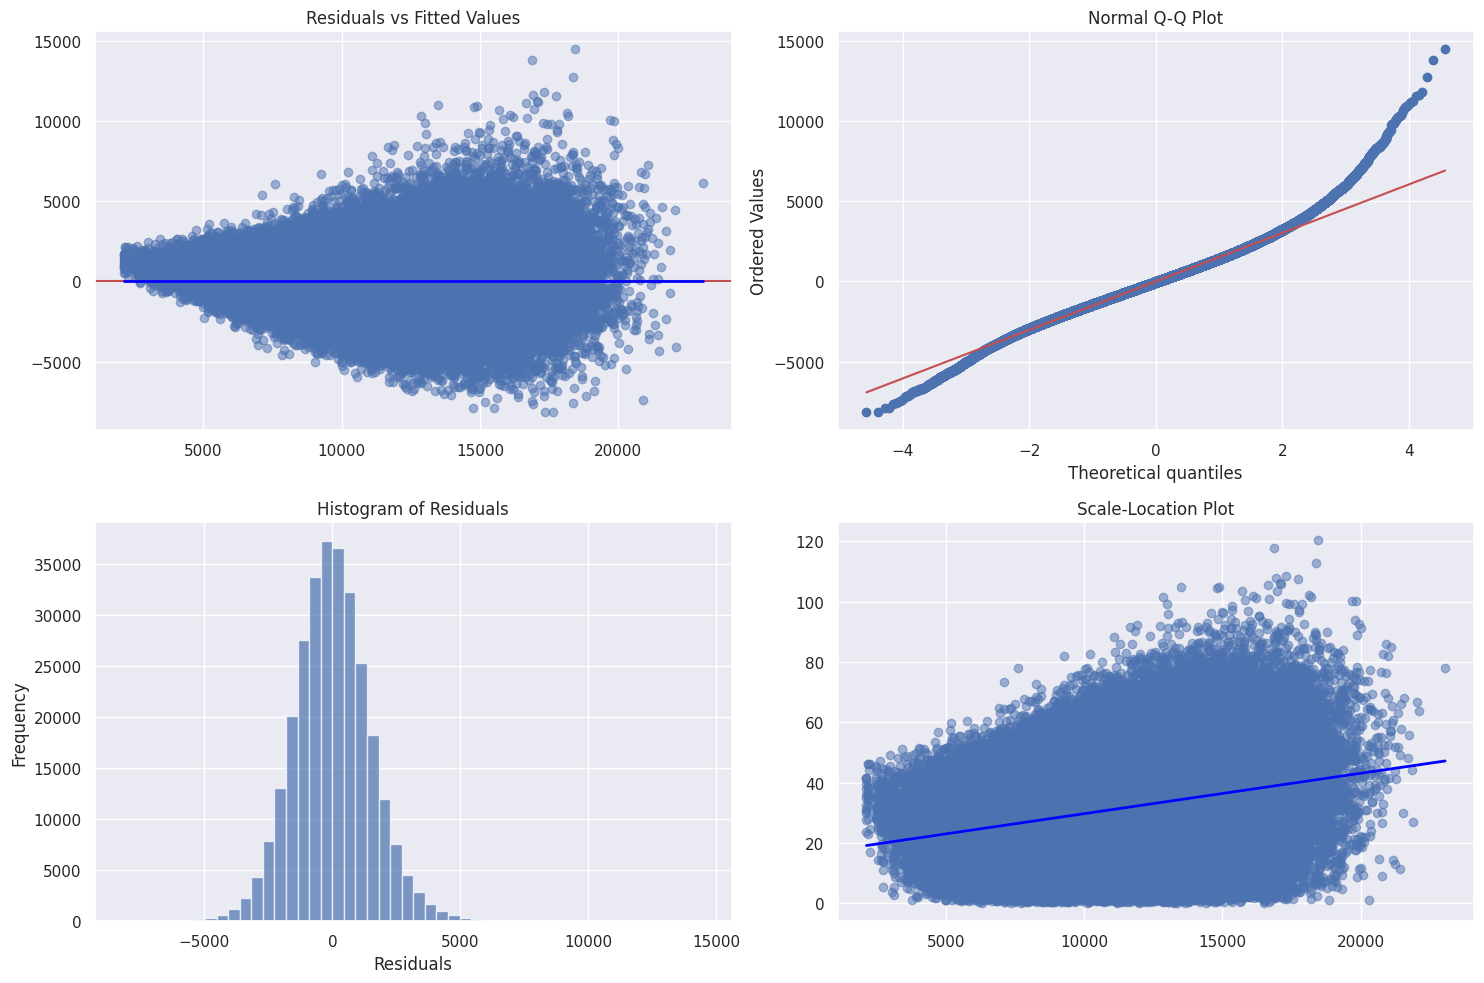

In [16]:
# Perform residual analysis on the regression model from the previous cell
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Get the residuals from the model
residuals = model.resid
fitted_values = model.fittedvalues

# Create a figure with multiple subplots for residual analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Residuals vs Fitted Values plot
axes[0, 0].scatter(fitted_values, residuals, alpha=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='-')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted Values')
sns.regplot(x=fitted_values, y=residuals, scatter=False, ax=axes[0, 0], color='blue', line_kws={'linewidth': 2})

# 2. QQ plot to check normality of residuals
stats.probplot(residuals, plot=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q Plot')

# 3. Histogram of residuals
axes[1, 0].hist(residuals, bins=50, alpha=0.7)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Histogram of Residuals')

# 4. Scale-Location plot (sqrt of abs residuals vs fitted values)
sqrt_abs_resid = np.sqrt(np.abs(residuals))
axes[1, 1].scatter(fitted_values, sqrt_abs_resid, alpha=0.5)
axes[1, 1].set_xlabel('Fitted Values')
axes[1, 1].set_ylabel('√|Residuals|')
axes[1, 1].set_title('Scale-Location Plot')
sns.regplot(x=fitted_values, y=sqrt_abs_resid, scatter=False, ax=axes[1, 1], color='blue', line_kws={'linewidth': 2})

# Add descriptive statistics of residuals
print("Residual Statistics:")
print(f"Mean of residuals: {residuals.mean():.6f}")
print(f"Standard deviation of residuals: {residuals.std():.6f}")
print(f"Skewness of residuals: {stats.skew(residuals):.6f}")
print(f"Kurtosis of residuals: {stats.kurtosis(residuals):.6f}")

# Perform Shapiro-Wilk test for normality (on a sample if dataset is large)
if len(residuals) > 5000:
    residual_sample = np.random.choice(residuals, size=5000, replace=False)
    shapiro_test = stats.shapiro(residual_sample)
    print(f"Shapiro-Wilk test on sample of 5000 residuals: W={shapiro_test[0]:.6f}, p-value={shapiro_test[1]:.6f}")
else:
    shapiro_test = stats.shapiro(residuals)
    print(f"Shapiro-Wilk test: W={shapiro_test[0]:.6f}, p-value={shapiro_test[1]:.6f}")

plt.tight_layout()
plt.show()


In [13]:
df.columns

Index(['date', 'center_id', 'tour_id', 'n_parcels', 'delivery_time',
       'delivery_time_per_parcel', 'is_outage', 'day_of_week', 'week_of_year',
       'month', 'quarter'],
      dtype='object')

In [17]:
# Regress delivery time on number of parcels and delivery center id
import statsmodels.api as sm
import numpy as np

# Convert categorical variables to numeric
df['center_id'] = df['center_id'].astype('category')
df['month'] = df['month'].astype('category')

# Create formula for regression
formula = "delivery_time_per_parcel ~ C(is_outage) + n_parcels + C(center_id)"

# Fit model using from_formula
model = sm.OLS.from_formula(formula, data=df).fit()

# Print summary
print(model.summary())

                               OLS Regression Results                               
Dep. Variable:     delivery_time_per_parcel   R-squared:                       0.427
Model:                                  OLS   Adj. R-squared:                  0.427
Method:                       Least Squares   F-statistic:                     5189.
Date:                      Sun, 02 Mar 2025   Prob (F-statistic):               0.00
Time:                              17:32:17   Log-Likelihood:            -1.0044e+06
No. Observations:                    292083   AIC:                         2.009e+06
Df Residuals:                        292040   BIC:                         2.009e+06
Df Model:                                42                                         
Covariance Type:                  nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

Residual Statistics:
Mean of residuals: 0.000000
Standard deviation of residuals: 7.535710
Skewness of residuals: 0.252712
Kurtosis of residuals: 0.826286
Shapiro-Wilk test on sample of 5000 residuals: W=0.993351, p-value=0.000000


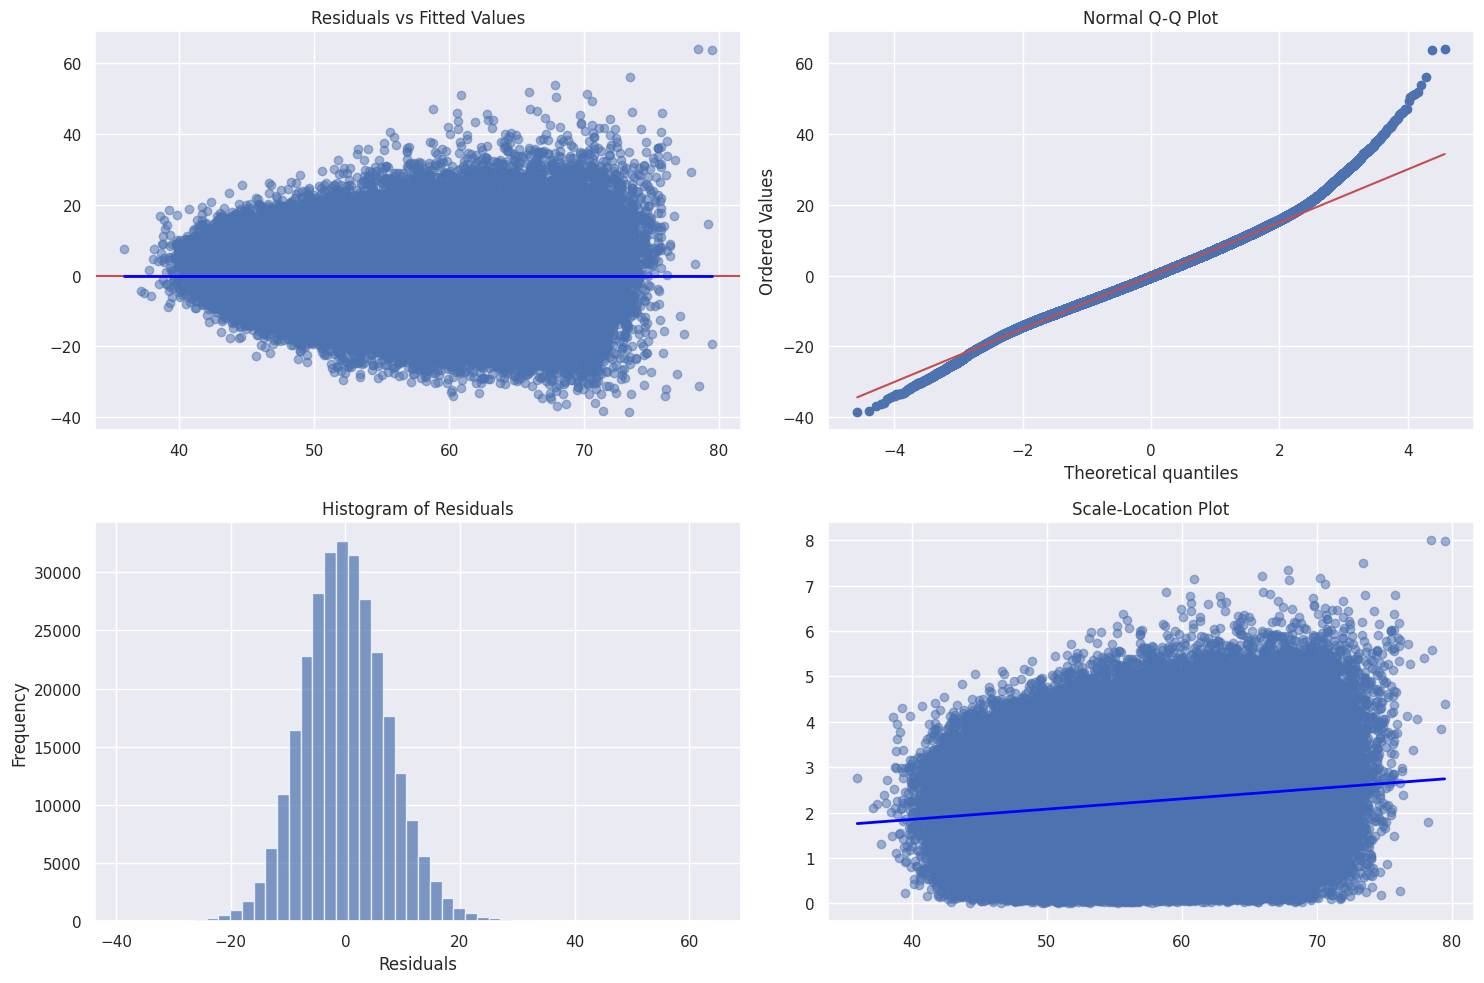

In [18]:
# Perform residual analysis on the regression model from the previous cell
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Get the residuals from the model
residuals = model.resid
fitted_values = model.fittedvalues

# Create a figure with multiple subplots for residual analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Residuals vs Fitted Values plot
axes[0, 0].scatter(fitted_values, residuals, alpha=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='-')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted Values')
sns.regplot(x=fitted_values, y=residuals, scatter=False, ax=axes[0, 0], color='blue', line_kws={'linewidth': 2})

# 2. QQ plot to check normality of residuals
stats.probplot(residuals, plot=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q Plot')

# 3. Histogram of residuals
axes[1, 0].hist(residuals, bins=50, alpha=0.7)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Histogram of Residuals')

# 4. Scale-Location plot (sqrt of abs residuals vs fitted values)
sqrt_abs_resid = np.sqrt(np.abs(residuals))
axes[1, 1].scatter(fitted_values, sqrt_abs_resid, alpha=0.5)
axes[1, 1].set_xlabel('Fitted Values')
axes[1, 1].set_ylabel('√|Residuals|')
axes[1, 1].set_title('Scale-Location Plot')
sns.regplot(x=fitted_values, y=sqrt_abs_resid, scatter=False, ax=axes[1, 1], color='blue', line_kws={'linewidth': 2})

# Add descriptive statistics of residuals
print("Residual Statistics:")
print(f"Mean of residuals: {residuals.mean():.6f}")
print(f"Standard deviation of residuals: {residuals.std():.6f}")
print(f"Skewness of residuals: {stats.skew(residuals):.6f}")
print(f"Kurtosis of residuals: {stats.kurtosis(residuals):.6f}")

# Perform Shapiro-Wilk test for normality (on a sample if dataset is large)
if len(residuals) > 5000:
    residual_sample = np.random.choice(residuals, size=5000, replace=False)
    shapiro_test = stats.shapiro(residual_sample)
    print(f"Shapiro-Wilk test on sample of 5000 residuals: W={shapiro_test[0]:.6f}, p-value={shapiro_test[1]:.6f}")
else:
    shapiro_test = stats.shapiro(residuals)
    print(f"Shapiro-Wilk test: W={shapiro_test[0]:.6f}, p-value={shapiro_test[1]:.6f}")

plt.tight_layout()
plt.show()


In [7]:
# Regress delivery time on number of parcels and delivery center id
import statsmodels.api as sm
import numpy as np

# Convert categorical variables to numeric
df['center_id'] = df['center_id'].astype('category').cat.codes
df['month'] = df['month'].astype('category').cat.codes

# Prepare features
features = ['n_parcels', 'center_id', 'month']
X = df[features].copy()

# Add dummy variables for categorical features
X = pd.get_dummies(X, columns=['center_id', 'month'], drop_first=True)

# Convert to float64
X = X.astype(np.float64)

# Add constant
X = sm.add_constant(X)

# Convert target to float64
y = df['delivery_time'].astype(np.float64)

# Fit model
model = sm.OLS(y, X).fit()

# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          delivery_time   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                 1.709e+04
Date:                Sun, 02 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:19:38   Log-Likelihood:            -2.5547e+06
No. Observations:              292083   AIC:                         5.109e+06
Df Residuals:                  292030   BIC:                         5.110e+06
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2883.5844     23.160    124.506   

In [8]:
analyze_results(df)

(                mean        std   count
 is_outage                              
 False      56.691071   9.679590  284835
 True       60.441875  17.333533    7248,
 np.float64(0.2671842706577837))

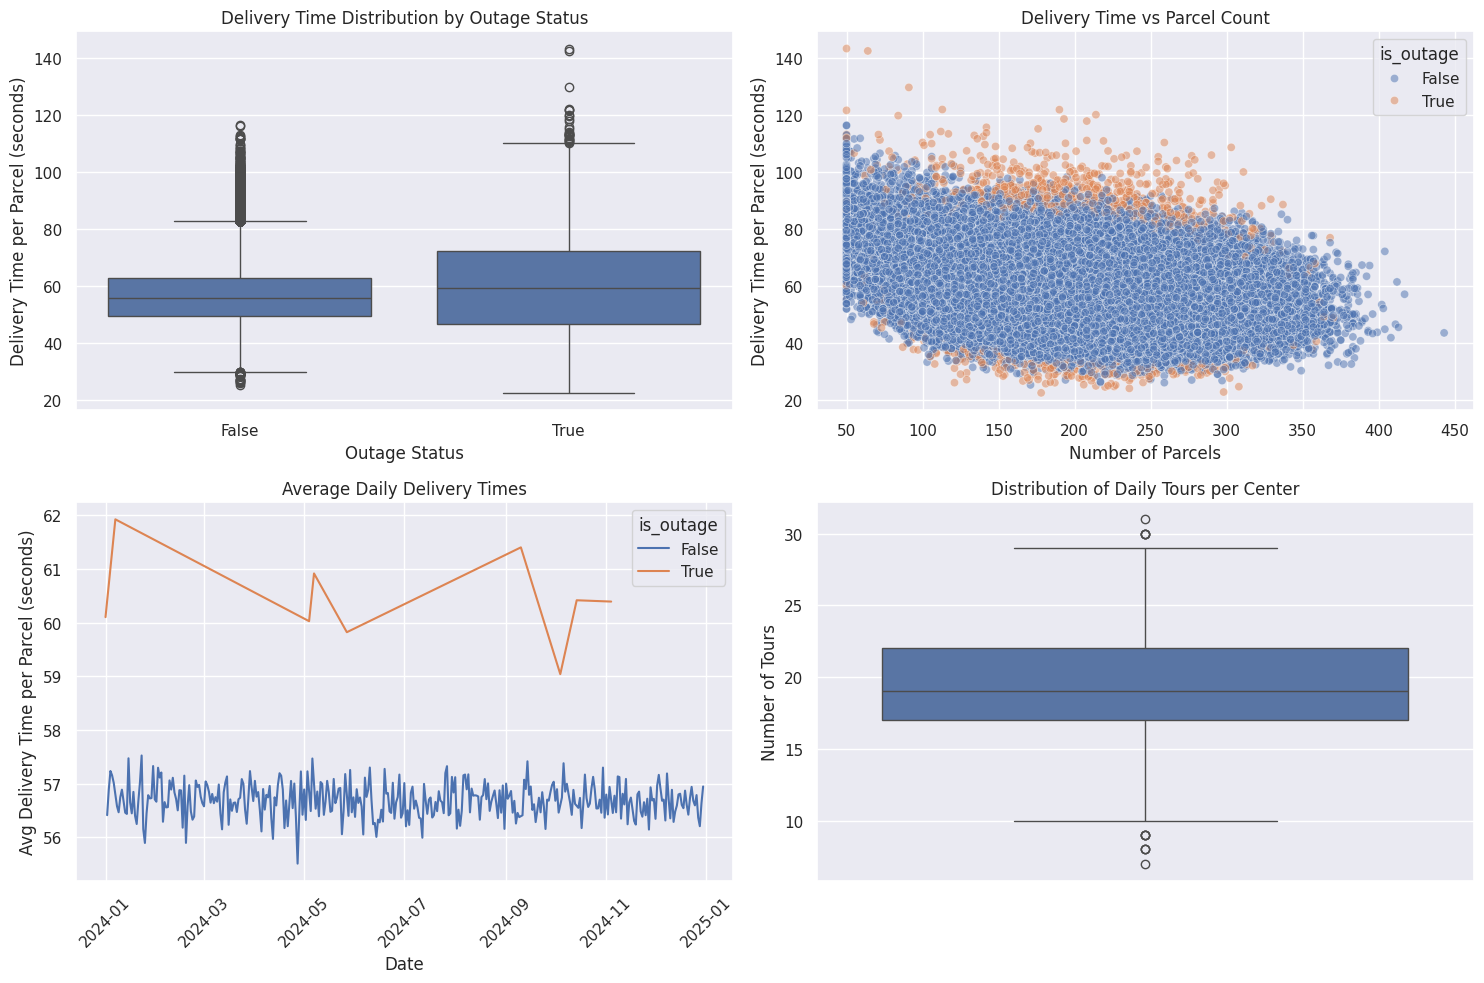

In [9]:
# visualize results
plot_results(df)







In [5]:
df

,date,center_id,tour_id,n_parcels,delivery_time,delivery_time_per_parcel,is_outage
0,2024-01-01,0,0,228,10568.032911,46.351022,False
1,2024-01-01,0,1,182,12454.085117,68.429039,False
2,2024-01-01,0,2,189,11546.052989,61.090227,False
3,2024-01-01,0,3,211,9130.795474,43.273912,False
4,2024-01-01,0,4,226,12077.761549,53.441423,False
...,...,...,...,...,...,...,...
292225,2024-12-30,40,12,210,11243.591191,53.540910,False
292226,2024-12-30,40,13,137,9648.579537,70.427588,False
292227,2024-12-30,40,14,247,12482.903543,50.538071,False
292228,2024-12-30,40,15,160,9450.743990,59.067150,False
